# Эх хэлний боловсруулалтыг программд нэвтрүүлэх нь

## Олон ангилал

In [ ]:
# ------------------------------
# Суурь сангууд
# ------------------------------
import os
import string
from io import StringIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# NLP (Natural Language Processing)
# ------------------------------
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
from textblob import TextBlob, Word

# ------------------------------
# Scikit-learn: онцлог шинж боловсруулах
# ------------------------------
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# ------------------------------
# Scikit-learn: өгөгдөл хуваах, урьдчилан боловсруулах
# ------------------------------
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split, cross_val_score

# ------------------------------
# Scikit-learn: загварууд
# ------------------------------
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


In [ ]:
# Татаж авсан өгөгдлийг унших
Data = pd.read_csv('consumer_complaints.csv', encoding='latin-1')


/tmp/ipython-input-1628613848.py:2: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  Data = pd.read_csv('consumer_complaints.csv', encoding='latin-1')


In [ ]:
# Баганын нэрсийг харах
print(Data.dtypes)


date_received                   object
product                         object
sub_product                     object
issue                           object
sub_issue                       object
consumer_complaint_narrative    object
company_public_response         object
company                         object
state                           object
zipcode                         object
tags                            object
consumer_consent_provided       object
submitted_via                   object
date_sent_to_company            object
company_response_to_consumer    object
timely_response                 object
consumer_disputed?              object
complaint_id                     int64
dtype: object


In [ ]:
# Шаардлагатай багануудыг сонгох
Data = Data[['product', 'consumer_complaint_narrative']]

# 'consumer_complaint_narrative' баганын утга хоосон биш (null биш) мөрүүдийг хадгалах
Data = Data[pd.notnull(Data['consumer_complaint_narrative'])]

# Эхний 5 мөрийг хэвлэх
print(Data.head())


                product                       consumer_complaint_narrative
190126  Debt collection  XXXX has claimed I owe them {$27.00} for XXXX ...
190135    Consumer Loan  Due to inconsistencies in the amount owed that...
190155         Mortgage  In XX/XX/XXXX my wages that I earned at my job...
190207         Mortgage  I have an open and current mortgage with Chase...
190208         Mortgage  XXXX was submitted XX/XX/XXXX. At the time I s...


In [ ]:
# 'product' баганыг тоон ангилалд хөрвүүлэх
Data['category_id'] = Data['product'].factorize()[0]

# Өгөгдлийн эхний 5 мөрийг хэвлэх
print(Data.head())

                product                       consumer_complaint_narrative  \
190126  Debt collection  XXXX has claimed I owe them {$27.00} for XXXX ...   
190135    Consumer Loan  Due to inconsistencies in the amount owed that...   
190155         Mortgage  In XX/XX/XXXX my wages that I earned at my job...   
190207         Mortgage  I have an open and current mortgage with Chase...   
190208         Mortgage  XXXX was submitted XX/XX/XXXX. At the time I s...   

        category_id  
190126            0  
190135            1  
190155            2  
190207            2  
190208            2  


In [ ]:
# Гомдлын ангилал тус бүрт ногдох гомдлын тоог тоолох
Data.groupby('product').consumer_complaint_narrative.count()

,consumer_complaint_narrative
product,
Bank account or service,5711
Consumer Loan,3678
Credit card,7929
Credit reporting,12526
Debt collection,17552
Money transfers,666
Mortgage,14919
Other financial service,110
Payday loan,726


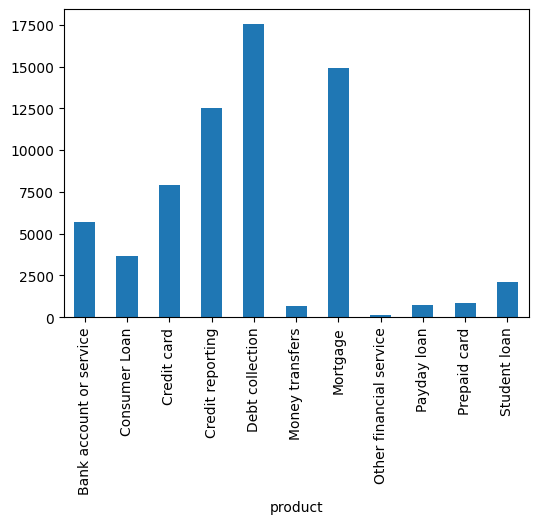

In [ ]:
# График дүрслэл үүсгэх
fig = plt.figure(figsize=(6,4))
Data.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()


In [ ]:
# Өгөгдлийг хуваах
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(Data['consumer_complaint_narrative'], Data['product'])

In [ ]:
# LabelEncoder-ээр ангиллын шошгыг тоон код руу хөрвүүлэх
encoder = preprocessing.LabelEncoder()

# Сургалтын шошго дээр fit, transform хийх
train_y = encoder.fit_transform(train_y)

# Үнэлгээний шошго дээр fit, transform хийх
valid_y = encoder.fit_transform(valid_y)

# TF-IDF векторизатор үүсгэх
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)

# Бүх өгөгдлийн текст дээр fit хийх
tfidf_vect.fit(Data['consumer_complaint_narrative'])

# Сургалтын болон үнэлгээний текст өгөгдлийг TF-IDF-д хөрвүүлэх
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [ ]:
# Логистик регрессийн загвар үүсгэж, сургалтын өгөгдөл дээр сургах
model = linear_model.LogisticRegression().fit(xtrain_tfidf, train_y)

# загварын нэгтгэл
LogisticRegression(
    C = 1.0,                  # Регуляцийн коэффициент
    class_weight = None,      # Ангиллын жинг тохируулах
    dual = False,             # Дуугаар тооцох эсэх
    fit_intercept = True,     # Интерсепт (байгуулагч) тооцох эсэх
    intercept_scaling = 1,    # Интерсептийн масштаб
    max_iter = 100,           # Итгэх түвшинд хүрэх хүртэлх давталтын тоо
    multi_class = 'ovr',      # Олон ангиллын аргын төрөл (“one-vs-rest”)
    n_jobs = 1,               # Олон CPU ашиглах эсэх
    penalty = 'l2',           # Регуляцийн төрөл (L2-регуляци)
    random_state = None,      # Санамсаргүй тооны эхлэл
    solver = 'liblinear',     # Оновчлох арга
    tol = 0.0001,             # Зохиомол зөрүүний зөвшөөрөгдөх хэмжээ
    verbose = 0,              # Илүү дэлгэрэнгүй мэдээлэл үзүүлэх эсэх
    warm_start = False        # Загварыг дахин ашиглах эсэх
)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

In [ ]:
# Үнэлгээний өгөгдлийн таамаглал гаргаж авах
predictions = model.predict(xvalid_tfidf)

# Нарийвчлал тооцох
accuracy = metrics.accuracy_score(valid_y, predictions)

# Үр дүн хэвлэх
print ("Accuracy: ", accuracy)
# Гаралт:
    # Accuracy:  0.845048497186


Accuracy:  0.8479822775715483


In [ ]:
# Ангиллын гүйцэтгэлийн тайлан хэвлэх
print(metrics.classification_report(
    valid_y,
    model.predict(xvalid_tfidf),
    target_names=Data['product'].unique()
))


                         precision    recall  f1-score   support

        Debt collection       0.81      0.80      0.81      1457
          Consumer Loan       0.80      0.60      0.69       981
               Mortgage       0.81      0.81      0.81      1949
            Credit card       0.85      0.85      0.85      3113
       Credit reporting       0.82      0.89      0.85      4372
           Student loan       0.79      0.54      0.64       164
Bank account or service       0.92      0.96      0.94      3733
            Payday loan       0.00      0.00      0.00        26
        Money transfers       0.61      0.28      0.38       175
Other financial service       0.82      0.71      0.76       214
           Prepaid card       0.90      0.80      0.85       518

               accuracy                           0.85     16702
              macro avg       0.74      0.66      0.69     16702
           weighted avg       0.84      0.85      0.84     16702



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


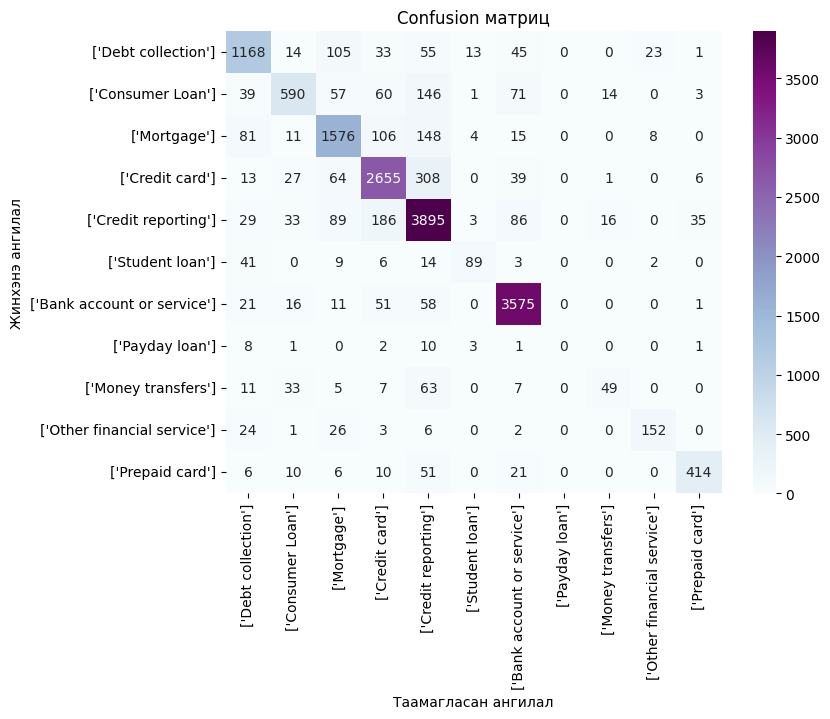

In [ ]:
# Confusion матриц үүсгэх
conf_mat = confusion_matrix(valid_y, model.predict(xvalid_tfidf))

# Ангиллын ID ба нэрийг холбосон датафрейм үүсгэх
category_id_df = Data[['product', 'category_id']].drop_duplicates().sort_values('category_id')

# Ангиллын нэрсийг axis-д үзүүлэхэд ашиглахын тулд жагсаалт гаргаж авах
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product']].values)


# График үүсгэх, confusion matrix-г дулаан зураг хэлбэрээр дүрслэх
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="BuPu",
            xticklabels=category_id_df[['product']].values, yticklabels=category_id_df[['product']].values)
plt.ylabel('Жинхэнэ ангилал')
plt.xlabel('Таамагласан ангилал')
plt.title('Confusion матриц')
plt.show()


In [ ]:
# Таамаглах текст
texts = ["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

# Шинэ текстийг TF-IDF формат руу хөрвүүлэх
text_features = tfidf_vect.transform(texts)

# Хөрвүүлсэн өгөгдөл дээр таамаглах
predictions = model.predict(text_features)

In [ ]:
# Текстийг хэвлэх
print(texts)
# Таамагласан ангиллыг хэвлэх
print("Таамагласан ангилал: '{}'".format(id_to_category[predictions[0]]))


['This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine.']
Таамагласан ангилал: 'Credit reporting'


## Хандлагын шинжилгээг хэрэгжүүлэх

In [ ]:
# Шаардлагатай сангуудыг импортлох
import numpy as np                  # Тоон өгөгдлийн боловсруулалт
import pandas as pd                 # Өгөгдөл унших, боловсруулах
import matplotlib.pyplot as plt     # Харагдац (visualization) үүсгэх

# Өгөгдлийг унших
df = pd.read_csv('Reviews.csv')     # Reviews.csv файлыг уншиж, DataFrame-д хадгалах

# Эхний 5 мөрийг харах
df.head(5)

In [ ]:
# Багана бүрийн өгөгдлийн төрлийг харах
df.info()

# Гаралт:
    # Data columns (total 10 columns):
    # Id                        5 non-null int64
    # ProductId                 5 non-null object
    # UserId                    5 non-null object
    # ProfileName               5 non-null object
    # HelpfulnessNumerator      5 non-null int64
    # HelpfulnessDenominator    5 non-null int64
    # Score                     5 non-null int64
    # Time                      5 non-null int64
    # Summary                   5 non-null object
    # Text                      5 non-null object
    # dtypes: int64(5), object(5)

In [ ]:
# Summary баганын эхний 5 утгыг харах
df.Summary.head(5)

# Гаралт:
    # 0    Good Quality Dog Food
    # 1        Not as Advertised
    # 2    “Delight” says it all
    # 3           Cough Medicine
    # 4              Great taffy
# dtype: object

In [ ]:
# Text буюу дэлгэрэнгүй тайлбарыг харах
df.Text.head(5)

# Гаралт:
    # 0    I have bought several of the Vitality canned d...
    # 1    Product arrived labeled as Jumbo Salted Peanut...
    # 2    This is a confection that has been around a fe...
    # 3    If you are looking for the secret ingredient i...
    # 4    Great taffy at a great price.  There was a wid...

In [ ]:
# Текстийг урьдчилан бэлтгэхэд шаардлагатай сангууд
from nltk.corpus import stopwords
from textblob import TextBlob, Word

# ‘Text’ баганын бүх үгийг жижиг үсэг рүү хөрвүүлэх
df['Text'] = df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Текстээс цэг, таслал зэрэг цэвэрлэх (тусгай тэмдэгтийг арилгах)
df['Text'] = df['Text'].str.replace('[^\w\s]', '')

# Цэвэрлэсэн ‘Text’ баганын эхний 5 мөрийг харах
df.Text.head(5)

# Гаралт:
    # 0    i have bought several of the vitality canned d...
    # 1    product arrived labeled as jumbo salted peanut...
    # 2    this is a confection that has been around a fe...
    # 3    if you are looking for the secret ingredient i...
    # 4    great taffy at a great price there was a wide ...

In [ ]:
import nltk
nltk.download('stopwords')
# Зогсоох үгсийг арилгах
stop = stopwords.words('english')

# 'Text' баганын өгөгдлөөс зогсоох үгсийг устгах
df['Text'] = df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

df.Text.head(4)
# Гаралт:
    # 0    bought several vitality canned dog food produc...
    # 1    product arrived labeled jumbo salted peanutsth...
    # 2    confection around centuries light pillowy citr...
    # 3    looking secret ingredient robitussin believe f...


In [ ]:
# Зөв бичгийн алдаа шалгах
df['Text'] = df['Text'].apply(lambda x: str(TextBlob(x).correct()))

df.Text.head(5)
# Гаралт:
    # 0    bought several vitality canned dog food produc...
    # 1    product arrived labelled lumbo halted peanutst...
    # 2    connection around centuries light pillow citie...
    # 3    looking secret ingredient robitussin believe f...
    # 4    great staff great price wide assortment mummy ...


In [ ]:
nltk.download('wordnet')
# ‘Text’ баганын үгсийг лемматизаци хийж, үндсэн хэлбэрт шилжүүлэх
df['Text'] = df['Text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df.Text.head(5)
# Гаралт:
    # 0    bought several vitality canned dog food produc...
    # 1    product arrived labelled lumbo halted peanutst...
    # 2    connection around century light pillow city ge...
    # 3    looking secret ingredient robitussin believe f...
    # 4    great staff great price wide assortment mummy ...

In [ ]:
# Датафрейм үүсгэх
reviews = df

# Null утгуудыг устгах (өгөгдлийг цэвэрлэх)
reviews.dropna(inplace=True)

# Үнэлгээний тархалтыг графикаар харуулах
reviews.Score.hist(bins=5, grid=False)
plt.xlabel('Score')           	# X тэнхлэгийн нэршил
plt.ylabel('Тоо хэмжээ')       	# Y тэнхлэгийн нэршил
plt.title('Үнэлгээний тархалт')  # Гистограммын гарчиг
plt.show()

# Үнэлгээ тус бүрд хэдэн сэтгэгдэл байгааг тоолох
print(reviews.groupby('Score').count().Id)

In [ ]:
min_count = 47  # хамгийн бага сэтгэгдлийн тоо

score_1 = reviews[reviews['Score'] == 1].sample(n=min_count)
score_2 = reviews[reviews['Score'] == 2].sample(n=min_count)
score_3 = reviews[reviews['Score'] == 3].sample(n=min_count)
score_4 = reviews[reviews['Score'] == 4].sample(n=min_count)
score_5 = reviews[reviews['Score'] == 5].sample(n=min_count)

# Тэнцвэртэй өгөгдлийг нэгтгэх
reviews_sample = pd.concat([score_1, score_2, score_3, score_4, score_5], axis=0)

# Индексыг дахин дэс дарааллаар шинээр үүсгэх
reviews_sample.reset_index(drop=True, inplace=True)

In [ ]:
# Score баганын үнэлгээ тус бүрийн давтамжийг шалгах
print(reviews_sample.groupby('Score').count().Id)

# Гаралт:
    # Score
    # 1    29743
    # 2    29743
    # 3    29743
    # 4    29743
    # 5    29743

In [ ]:
# Summary баганын үгсээр үгэн үүл (Word Cloud) үүсгэх
from wordcloud import WordCloud
from wordcloud import STOPWORDS

# Wordcloud функцийн оролт нь дан тэмдэгт мөр байх шаардлагатай.
# Тиймээс энд бүх текстийг залгаж нэг тэмдэгт мөр болгоно.
# Үүнтэй адил Text баганыг нэгтгэх боломжтой.
reviews_str = reviews_sample.Summary.str.cat()

# # Үгэн үүл үүсгэх объект
wordcloud = WordCloud(background_color='white').generate(reviews_str)

# Үгэн үүлийг зурж харуулах
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Тэнхлэгийг нуух
plt.title('Summary баганын үгсийн үгэн үүл')
plt.show()

In [ ]:
# өгөгдлийг Negative (оноо 1-2) болон Positive (оноо 4-5) гэж хуваах
negative_reviews = reviews_sample[reviews_sample['Score'].isin([1,2]) ]
positive_reviews = reviews_sample[reviews_sample['Score'].isin([4,5]) ]

# Тус бүрийн Summary-г нэг мөр болгон нийлүүлэх
negative_reviews_str = negative_reviews.Summary.str.cat()
positive_reviews_str = positive_reviews.Summary.str.cat()

# Negative үнэлгээний үгсийн үгэн үүл үүсгэх
wordcloud_negative = WordCloud(background_color='white').generate(negative_reviews_str)

# Positive үнэлгээний үгсийн үгэн үүл үүсгэх
wordcloud_positive = WordCloud(background_color='white').generate(positive_reviews_str)


In [ ]:
# Сөрөг үнэлгээтэй санал хүсэлтийн үгэн үүл зурж харуулах
fig = plt.figure(figsize=(10, 10)) # графикийн хэмжээ
ax1 = fig.add_subplot(211)
ax1.imshow(wordcloud_negative, interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Сөрөг үнэлгээтэй санал хүсэлтүүд', fontsize=20)

In [ ]:
# Эерэг үнэлгээтэй санал хүсэлтийн үгэн үүл зурж харуулах
ax2 = fig.add_subplot(212)
ax2.imshow(wordcloud_positive, interpolation='bilinear')
ax2.axis("off")
ax2.set_title('Эерэг үнэлгээтэй санал хүсэлтүүд', fontsize=20)

# Графикуудыг харуулах
plt.show()

In [ ]:
# Шаардлагатай сангуудыг импортлох
import pandas as pd        # Өгөгдөл боловсруулах
import numpy as np         # Тооцоолол хийх
import matplotlib.pyplot as plt  # График зураг гаргах
import seaborn as sns      # График загварчлахад туслах
import re                  # Текст боловсруулах (регуляр илэрхийлэл)
import os                  # Файлын системтэй ажиллах
import sys                 # Системийн түвшний команд удирдах
import ast                 # Текстийг Python объект болгон хөрвүүлэх

# График харуулах тохиргоо
%matplotlib inline
plt.style.use('fivethirtyeight')  # Графикийн загвар тохируулах


In [ ]:
# VADER сэтгэгдлийн шинжилгээ хийх модуль
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Өнгөний палитр авах (зураг, графикт өнгө тохируулахад ашиглана)
cp = sns.color_palette()

# VADER сэтгэгдлийн шинжилгээ хийх объектыг үүсгэж байна
analyzer = SentimentIntensityAnalyzer()

In [ ]:
# Датафреймийн 'Text' баганын бүх өгүүлбэрт сэтгэгдлийн хандлагыг тодорхойлох
# Хандлагын үр дүнг хадгалах хоосон жагсаалт
emptyline=[]
for row in df['Text']:
        # Тухайн өгүүлбэрийн сэтгэгдлийн оноог тооцох
    vs=analyzer.polarity_scores(row)
    emptyline.append(vs)

NameError: name 'df' is not defined

In [ ]:
# Хандлагын шинжилгээний үр дүнг датафрейм болгон хувиргах
df_sentiments=pd.DataFrame(emptyline)

# Эхний 5 мөрийг харах
df_sentiments.head(5)

# Гаралт:
    #     compound    neg     neu     pos
    # 0     0.9413    0.000   0.503   0.497
    # 1    -0.5719    0.258   0.644   0.099
    # 2     0.8031    0.133   0.599   0.268
    # 3     0.4404    0.000   0.854   0.146
    # 4     0.9186    0.000   0.455   0.545

In [ ]:
# Санал хүсэлтийн өгөгдөл болон хандлагын оноог нэгтгэх
df_c = pd.concat([df.reset_index(drop=True), df_sentiments], axis=1)

# Эхний 3 мөрийг харах
df_c.head(3)

In [ ]:
# Compound оноог эерэг болон сөрөг хандлага руу ангилах
df_c['Sentiment'] = np.where(df_c['compound'] >= 0 , 'Positive', 'Negative')

# Эхний 5 мөрийг харах
df_c.head(5)

In [ ]:
# Эерэг болон сөрөг хандлагын тоог тоолох
result=df_c['Sentiment'].value_counts()

# Хандлагын тоог баганан графикаар харуулах
result.plot(kind='bar', rot=0, color=['b', 'r']);

In [ ]:
# Бүтээгдэхүүн тус бүрийн хандлагын тоог тоолох
result=df_c.groupby('ProductId')['Sentiment'].value_counts().unstack()

# Сөрөг ба эерэг хандлагын тоог баганан графикаар дүрслэх
result[['Negative', 'Positive']].plot(kind='bar', rot=0, color='rb')


## Текстийн төстэй байдал

In [1]:
# recordlinkage санг суулгах
!pip install recordlinkage

# recordlinkage санг импортлох
import recordlinkage

# Өгөгдлийн сангаас жишээ өгөгдөл унших
from recordlinkage.datasets import load_febrl1

# Өгөгдлийн DataFrame үүсгэж, эхний хэдэн мөрийг харах
dfA = load_febrl1()
dfA.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.9/926.9 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 34.0 MB/s eta 0:00:00


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-223-org,NaN,waller,6,tullaroop street,willaroo,st james,4011,wa,19081209,6988048
rec-122-org,lachlan,berry,69,giblin street,killarney,bittern,4814,qld,19990219,7364009
rec-373-org,deakin,sondergeld,48,goldfinch circuit,kooltuo,canterbury,2776,vic,19600210,2635962
rec-10-dup-0,kayla,harrington,NaN,maltby circuit,coaling,coolaroo,3465,nsw,19150612,9004242
rec-227-org,luke,purdon,23,ramsay place,mirani,garbutt,2260,vic,19831024,8099933


In [3]:
# 'given_name' баганаар блок үүсгэх
indexer = recordlinkage.Index()
indexer.block(on='given_name')

# Блок үүсгэсний дараа боломжит бичлэгийн хосыг гаргаж авах
pairs = indexer.index(dfA)

# Хосын тоог хэвлэх
print (len(pairs))	# Гаралт: 2082

2082


In [5]:
# Тооцоололд хугацаа шаардаж магадгүй.
compare_cl = recordlinkage.Compare()

# Нэр дээр Jaro-Winkler арга ашиглан төстэй байдлыг тооцоолно
compare_cl.string('given_name', 'given_name', method='jarowinkler', label='given_name')

# Овог дээр мөн Jaro-Winkler арга
compare_cl.string('surname', 'surname', method='jarowinkler', label='surname')

# Төрсөн огноо дээр яг тулгалт хийнэ
compare_cl.exact('date_of_birth', 'date_of_birth', label='date_of_birth')

# Хот (suburb) дээр яг тулгалт
compare_cl.exact('suburb', 'suburb', label='suburb')

# Муж (state) дээр яг тулгалт
compare_cl.exact('state', 'state', label='state')

# Хаяг дээр Jaro-Winkler ашиглана
compare_cl.string('address_1', 'address_1', method='jarowinkler', label='address_1')

# Бичлэгийн хосууд дээр тооцоолол хийх
features = compare_cl.compute(pairs, dfA)

# Төстэй байдлын оноог санамсаргүй 5 мөрөөр харуулах
features.sample(5)

,,given_name,surname,date_of_birth,suburb,state,address_1
rec_id_1,rec_id_2,,,,,,
rec-52-dup-0,rec-415-org,1.0,0.441667,0,0,0,0.447802
rec-83-dup-0,rec-491-org,1.0,0.600000,0,0,1,0.472222
rec-481-org,rec-200-dup-0,1.0,0.495833,0,0,0,0.554837
rec-359-org,rec-278-org,1.0,0.000000,0,0,0,0.482323
rec-451-org,rec-444-dup-0,1.0,0.490079,0,0,0,0.631624


In [6]:
# Блоклох түлхүүр 'given_name'-ээс бусад бүх шинж чанарыг сонгох
# blockin key: given_name
features1 = features[['suburb', 'state', 'surname', 'date_of_birth', 'address_1']]

# Удирдамжгүй сургалт ашиглан магадлалыг тодорхойлох
ecm = recordlinkage.ECMClassifier()

# Сонгосон шинж чанаруудыг бүхэл тоон хэлбэрт хөрвүүлэн сургалт явуулах
result_ecm = ecm.learn((features1).astype(int), return_type='series')

# Урьдчилсан таамаглалын үр дүнг харуулах
result_ecm


/tmp/ipython-input-369631433.py:9: UserWarning: learn is deprecated, ECMClassifier.fit_predict instead
  result_ecm = ecm.learn((features1).astype(int), return_type='series')


rec_id_1       rec_id_2     
rec-251-org    rec-251-dup-0    1
rec-284-dup-0  rec-67-org       0
rec-335-dup-0  rec-335-org      1
rec-23-dup-0   rec-23-org       1
rec-32-dup-0   rec-70-org       0
                               ..
rec-469-dup-0  rec-183-org      0
               rec-360-dup-0    0
               rec-248-dup-0    0
rec-350-dup-0  rec-350-org      1
               rec-242-org      0
Name: classification, Length: 2082, dtype: int64

### Олон хүснэгтээс хэрэглэгчийн бүртгэл таних

In [7]:
# recordlinkage сангаас жишээ өгөгдлийг импортлох
from recordlinkage.datasets import load_febrl4

# Олон хүснэгтээс өгөгдөл унших
dfA, dfB = load_febrl4()

# Эхний хүснэгтийн эхний хэдэн мөрийг харах
dfA.head()

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-1070-org,michaela,neumann,8,stanley street,miami,winston hills,4223,nsw,19151111,5304218
rec-1016-org,courtney,painter,12,pinkerton circuit,bega flats,richlands,4560,vic,19161214,4066625
rec-4405-org,charles,green,38,salkauskas crescent,kela,dapto,4566,nsw,19480930,4365168
rec-1288-org,vanessa,parr,905,macquoid place,broadbridge manor,south grafton,2135,sa,19951119,9239102
rec-3585-org,mikayla,malloney,37,randwick road,avalind,hoppers crossing,4552,vic,19860208,7207688


In [8]:
# Хоёр дахь өгөгдлийн хүснэгтийн эхний 5 мөрийг харах
dfB.head()

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-561-dup-0,elton,NaN,3,light setreet,pinehill,windermere,3212,vic,19651013,1551941
rec-2642-dup-0,mitchell,maxon,47,edkins street,lochaoair,north ryde,3355,nsw,19390212,8859999
rec-608-dup-0,NaN,white,72,lambrigg street,kelgoola,broadbeach waters,3159,vic,19620216,9731855
rec-3239-dup-0,elk i,menzies,1,lyster place,NaN,northwood,2585,vic,19980624,4970481
rec-2886-dup-0,NaN,garanggar,NaN,may maxwell crescent,springettst arcade,forest hill,2342,vic,19921016,1366884


In [9]:
# Блок индекс үүсгэх: 'given_name' баганаар бичлэгүүдийг бүлэглэх
indexer = recordlinkage.Index().block(on='given_name')

# dfA, dfB хоёр өгөгдлийн хүрээнээс боломжит бичлэгийн хосуудыг үүсгэх
pairs = indexer.index(dfA, dfB)

In [10]:
# Бичлэгүүдийн ижил төстэй байдлыг харьцуулах объект үүсгэх
compare_cl = recordlinkage.Compare()

# Төсөөт байдлыг хэмжих шалгууруудыг тодорхойлох
compare_cl.string('given_name', 'given_name', method='jarowinkler', label='given_name')
compare_cl.string('surname', 'surname', method='jarowinkler', label='surname')
compare_cl.exact('date_of_birth', 'date_of_birth', label='date_of_birth')
compare_cl.exact('suburb', 'suburb', label='suburb')
compare_cl.exact('state', 'state', label='state')
compare_cl.string('address_1', 'address_1', method='jarowinkler', label='address_1')

# Сонгосон шалгууруудаар харьцуулалт хийх
features = compare_cl.compute(pairs, dfA, dfB)

# Эхний 10 бичлэгийн харьцуулалтын үр дүнг харуулах
features.head(10)

given_name   surname  date_of_birth  suburb  \
rec_id_1     rec_id_2                                                      
rec-1070-org rec-3024-dup-0         1.0  0.436508              0       0   
             rec-2371-dup-0         1.0  0.490079              0       0   
             rec-4652-dup-0         1.0  0.490079              0       0   
             rec-4795-dup-0         1.0  0.000000              0       0   
             rec-1314-dup-0         1.0  0.000000              0       0   
rec-1016-org rec-1209-dup-0         1.0  0.000000              0       0   
             rec-1151-dup-0         1.0  0.742857              0       0   
             rec-4141-dup-0         1.0  0.345238              0       0   
             rec-4215-dup-0         1.0  0.539683              0       0   
             rec-2463-dup-0         1.0  0.539683              0       0   

                             state  address_1  
rec_id_1     rec_id_2                          
rec-1070-org rec-3024-dup-0      1   0.000000  
             rec-2371-dup-0      0   0.715873  
             rec-4652-dup-0      0   0.645604  
             rec-4795-dup-0      1   0.552381  
             rec-1314-dup-0      1   0.618254  
rec-1016-org rec-1209-dup-0      1   0.464706  
             rec-1151-dup-0      0   0.464869  
             rec-4141-dup-0      0   0.578525  
             rec-4215-dup-0      0   0.671517  
             rec-2463-dup-0      0   0.570324

In [12]:
# Блок түлхүүр болох 'given_name' баганыг орхиж, бусад бүх онцлогуудыг сонгох
features1 = features[['suburb', 'state', 'surname', 'date_of_birth', 'address_1']]

# Удирдамжгүй сургалт ашиглан таарах магадлалыг тооцоолох
ecm = recordlinkage.ECMClassifier()
result_ecm = ecm.learn((features1).astype(int), return_type='series')

# Урьдчилсан дүгнэлтийг харуулах
result_ecm

/tmp/ipython-input-4275665800.py:6: UserWarning: learn is deprecated, ECMClassifier.fit_predict instead
  result_ecm = ecm.learn((features1).astype(int), return_type='series')


rec_id_1      rec_id_2      
rec-1070-org  rec-3024-dup-0    0
              rec-2371-dup-0    0
              rec-4652-dup-0    0
              rec-4795-dup-0    0
              rec-1314-dup-0    0
                               ..
rec-1003-org  rec-3321-dup-0    0
rec-4883-org  rec-4883-dup-0    1
rec-66-org    rec-3318-dup-0    0
              rec-66-dup-0      1
              rec-3838-dup-0    0
Name: classification, Length: 77249, dtype: int64

## Текст хураангуйлах

### TextRank арга

In [13]:
# BeautifulSoup, urllib сангуудыг импортлох
# Википедиагаас веб өгөгдөл татаж, HTML бүтэцтэй ажиллахад ашиглана.
from bs4 import BeautifulSoup	 # HTML өгөгдлийг задлан боловсруулах
from urllib.request import urlopen # Веб хуудас руу хандаж өгөгдөл татах
import urllib.request

In [18]:
# Википедиагаас өгөгдөл авах функц
# Өгөгдсөн URL-с HTML өгөгдөл татаж, бүх <p> таг доторх агуулгыг нэгтгэн буцаана.
def get_only_text(url):
    # Header тодорхойлох
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122 Safari/537.36'
        )
    }

     # HTTP хүсэлт илгээх
    req = urllib.request.Request(url, headers=headers)
    with urllib.request.urlopen(req) as response:
        html = response.read()

    # HTML-г BeautifulSoup ашиглан задлах
    soup = BeautifulSoup(html, 'html.parser')

    # <p> таг доторх текстийг нэгтгэх
    text = ' '.join(p.get_text() for p in soup.find_all('p'))

    # Хуудасны гарчгийг шалгаж авах
    title = soup.title.string.strip() if soup.title else "No title"

    # Хэрэгтэй бол эхний 500 тэмдэгт хэвлэх
    print(text[:500])

    return title, text

In [19]:
# Өгөгдөл татах холбоос
url = "https://en.wikipedia.org/wiki/Natural_language_processing"

# fetch_text_from_url функцийг дуудах
text = get_only_text(url)

# Текст өгөгдлийн нийт тэмдэгтийн тоог гаргах
len(''.join(text))
# Гаралт: 6271

Natural language processing (NLP) is the processing of natural language information by a computer. The study of NLP, a subfield of computer science, is generally associated with artificial intelligence. NLP is related to information retrieval, knowledge representation, computational linguistics, and more broadly with linguistics.[1]
 Major processing tasks in an NLP system include: speech recognition, text classification, natural language understanding, and natural language generation.
 Natural 


6271

In [20]:
# Текстийн эхний 500 тэмдэгтийг харах
text[:500]

('Natural language processing - Wikipedia',
 'Natural language processing (NLP) is the processing of natural language information by a computer. The study of NLP, a subfield of computer science, is generally associated with artificial intelligence. NLP is related to information retrieval, knowledge representation, computational linguistics, and more broadly with linguistics.[1]\n Major processing tasks in an NLP system include: speech recognition, text classification, natural language understanding, and natural language generation.\n Natural language processing has its roots in the 1950s.[2] Already in 1950, Alan Turing published an article titled "Computing Machinery and Intelligence" which proposed what is now called the Turing test as a criterion of intelligence, though at the time that was not articulated as a problem separate from artificial intelligence. The proposed test includes a task that involves the automated interpretation and generation of natural language.\n The premise 

In [21]:
# sumy багц суулгах
!pip install sumy

# Өгөгдсөн текстээс өгүүлбэрүүдийг салгах parser
from sumy.parsers.plaintext import PlaintextParser

# Текстийг өгүүлбэр болон үг болгон хуваах
from sumy.nlp.tokenizers import Tokenizer

# Текстийг хураангуйлах класс
from sumy.summarizers.text_rank import TextRankSummarizer

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 74.9 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21695 sha256=61e9511c94b489155f1249baddb5bc167673fcc777719345fef0cb0005584562
  Stored in directory: /root/.cache/pip/wheels/32/99/64/59305409cacd03aa03e7bddf31a9db34b1fa7033bd41972662
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=ae032b7be14e13816b1d61329e833f56fef941e8ab47be4911368d6a35327d23
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built breadability docopt


In [24]:
import nltk
nltk.download('punkt_tab')
# Текстийг parse хийх
parser = PlaintextParser.from_string(text, Tokenizer("english"))

# TextRank алгоритмаар хураангуйлагч үүсгэх
summarizer = TextRankSummarizer()

# Текстийг 2 өгүүлбэрээр хураангуйлах
summary = summarizer(parser.document, 2)

# Хураангуйг хэвлэх
for sentence in summary:
    print(sentence)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


[9]\n Symbolic approach, i.e., the hand-coding of a set of rules for manipulating symbols, coupled with a dictionary lookup, was historically the first approach used both by AI in general and by NLP in particular:[19][20] such as by writing grammars or devising heuristic rules for stemming.\n Machine learning approaches, which include both statistical and neural networks, on the other hand, have many advantages over the symbolic approach: \n Rule-based systems are commonly used:\n In the late 1980s and mid-1990s, the statistical approach ended a period of AI winter, which was caused by the inefficiencies of the rule-based approaches.
[50] Especially during the age of symbolic NLP, the area of computational linguistics maintained strong ties with cognitive studies.\n As an example, George Lakoff offers a methodology to build natural language processing (NLP) algorithms through the perspective of cognitive science, along with the findings of cognitive linguistics,[51] with two defining a

### Онцлог шинж дээр суурилсан хураангуйлах арга

In [26]:
# sumy санг суулгах
!pip install sumy
c
# HTML форматтай веб хуудсаас текст татаж, задлахад ашиглагдах parser
from sumy.parsers.html import HtmlParser

# Энгийн текстээс өгүүлбэр салгах parser.
from sumy.parsers.plaintext import PlaintextParser

# Текстийг өгүүлбэр, үг болгон хуваах tokenizer
from sumy.nlp.tokenizers import Tokenizer

# Латент семантик анализ (LSA) дээр суурилсан текст хураангуйлагч
from sumy.summarizers.lsa import LsaSummarizer

# Үгийн үндсийг ялгаж авах (stemming) хэрэгсэл.
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

# Luhn алгоритмаар текстийг хураангуйлах зориулалттай класс
from sumy.summarizers.luhn import LuhnSummarizer

In [28]:
# Задлан унших болон хураангуйлах процессын тохиргоо
LANGUAGE = "english" # Текстийг англи хэл дээр боловсруулна гэдгийг заана
SENTENCES_COUNT = 2 # Хураангуйлалтад авах өгүүлбэрийн тоо

url= "https://en.wikipedia.org/wiki/Natural_language_processing"

# Өгөгдсөн хэлний дүрмийн дагуу текстийг өгүүлбэр болгон хуваах
parser = HtmlParser.from_url(url, Tokenizer(LANGUAGE))

# LSA объект ашиглан үгийн үндсийг ялгах
summarizer = LsaSummarizer(Stemmer(LANGUAGE))

# Ач холбогдол багатай үгсийг арилгах
summarizer.stop_words = get_stop_words(LANGUAGE)

# Заасан өгүүлбэрийн тоогоор хураангуйлах
for sentence in summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)


Retrieved 5 December 2021.^ Yi, Chucai; Tian, Yingli(2012), "Assistive Text Reading from Complex Background for Blind Persons", Camera-Based Document Analysis and Recognition, Lecture Notes in Computer Science, vol.
Advances in Neural Information Processing Systems.^ Kariampuzha, William; Alyea, Gioconda; Qu, Sue; Sanjak, Jaleal; Mathé, Ewy; Sid, Eric; Chatelaine, Haley; Yadaw, Arjun; Xu, Yanji; Zhu, Qian (2023).


## Баримтын кластер

In [29]:
!pip install mpld3
import os
import re
import codecs

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Matplotlib-ийн графикуудыг веб дээр харуулах сан
import mpld3

from bs4 import BeautifulSoup
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn import feature_extraction
from sklearn.metrics.pairwise import cosine_similarity

# Олон хэмжээст өгөгдлийг 2D эсвэл 3D орон зайд дүрслэх
from sklearn.manifold import MDS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 5.4 MB/s eta 0:00:00


In [30]:
# Өгөгдлийг унших
Data = pd.read_csv("consumer_complaints.csv", encoding='latin-1')

# Зөвхөн шаардлагатай баганыг сонгох
Data = Data[['consumer_complaint_narrative']]

# Хоосон мөрүүдийг (NaN) арилгах
Data = Data[pd.notnull(Data['consumer_complaint_narrative'])]

#  Жишээ болгон 200 баримтыг санамсаргүй байдлаар сонгох
Data_sample = Data.sample(200, replace=True)

/tmp/ipython-input-223710461.py:2: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  Data = pd.read_csv("consumer_complaints.csv", encoding='latin-1')


In [31]:
# Хэрэгцээгүй тэмдэгтийг арилгах
Data_sample['consumer_complaint_narrative'] = Data_sample['consumer_complaint_narrative'].str.replace('XXXX', '')

In [32]:
# Датафреймийг жагсаалт руу хөрвүүлэх
complaints = Data_sample['consumer_complaint_narrative'].tolist()

In [34]:
import nltk
nltk.download('stopwords')
# Баримтын эрэмбэ хадгалагчийг үүсгэх ба үүнийг дараа ашиглана
ranks = list(range(1, len(complaints) + 1))

# Зогсоох үгс
stopwords = nltk.corpus.stopwords.words('english')

# Үгийн үндэс тодорхойлогч
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
# Текстийг токенжуулж, үгийн үндсийг (stem) гаргах функц
def tokenize_and_stem(text):
    # Токенжуулалт
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    # Латин үсэг агуулсан үгсийг шүүх
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    # Язгуур хэлбэрт оруулах
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


In [36]:
# Текстийг зөвхөн токенжуулж буцаах функц
def tokenize_only(text):
    # токенжуулалт + бүх үгийг жижиг үсэг болгох
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    # Зөвхөн латин үсэг агуулсан үгсийг шүүх
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    return filtered_tokens

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF вектор үүсгэх
tfidf_vectorizer = TfidfVectorizer(
    max_df = 0.8,               # Хэт давтамжтай үгсийг хасах (80%-иас их гарсан үгс)
    max_features = 200000,      # Хамгийн их хадгалах онцлог шинжийн тоо
    min_df = 0.2,               # Хэт ховор үгсийг хасах (20%-иас бага давтамжтай)
    stop_words = 'english',     # Stopwords-ийг устгах
    use_idf = True,             # IDF жин ашиглах
    tokenizer = tokenize_and_stem, # Өөрийн функц ашиглах
    ngram_range = (1,3)         # unigram, bigram, trigram-г оруулах
)

# TF-IDF матриц үүсгэх (баримтуудыг вектор болгож хөрвүүлэх)
tfidf_matrix = tfidf_vectorizer.fit_transform(complaints)

# Онцлог үгийн нэрсийг авах
terms = tfidf_vectorizer.get_feature_names_out()
print("TF-IDF матрицын хэмжээ:", tfidf_matrix.shape)

# Гаралт: TF-IDF матрицын хэмжээ: (200, 27)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev'

TF-IDF матрицын хэмжээ: (200, 28)


### Kmeans кластер

In [38]:
# KMeans кластер үүсгэхэд шаардлагатай классыг импортлох
from sklearn.cluster import KMeans

# Кластер үүсгэхэд ашиглах кластерын тоог тодорхойлох
num_clusters = 6

# K-means алгоритмын объект үүсгэх
km = KMeans(n_clusters=num_clusters)

# TF-IDF матриц дээр K-means алгоритмыг ажиллуулж кластер үүсгэх
km.fit(tfidf_matrix)

KMeans(n_clusters=6)

In [39]:
# Баримт тус бүр аль кластерт багтсаныг жагсаалтаар авах
clusters = km.labels_.tolist()

# Баримт, эрэмбэ, кластерын мэдээллийг нэг датафреймд нэгтгэх
complaints_data = {
    'rank': ranks, 		# Баримтын эрэмбэ
    'complaints': complaints, # Баримтын текст
    'cluster': clusters  	# Таамагласан кластерын индекс
}
frame = pd.DataFrame(complaints_data, index=[clusters], columns=['rank', 'cluster'])

# Кластер тус бүрт хэдэн баримт байгааг тоолох
frame['cluster'].value_counts()

,count
cluster,
5,46
4,41
1,38
0,35
3,23
2,17


In [41]:
# Бүх баримтын язгуур хэлбэрт хөрвүүлсэн үгс хадгалах жагсаалт
totalvocab_stemmed = []

# Бүх баримтын токенжуулсан үгс хадгалах жагсаалт
totalvocab_tokenized = []

# Баримт тус бүрээр давтах
for i in complaints:
    # токенжуулж, язгуур хэлбэрт хөрвүүлэх
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)

    # зөвхөн токенжуулсан үгсийг авах
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

# Язгуур үгсийг индекс, токенжуулсан үгсийг утга болгох датафрейм үүсгэх
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

# K-means кластерын төвүүдийг эрэмбэлэх
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

In [42]:
# Кластер бүрт хамгийн их нөлөөтэй 6 үгийг хэвлэх
for i in range(num_clusters):
    # Кластерын дугаарын эхлэлийн мөр
    print("Кластер %d үгс:" % i, end='')

    for ind in order_centroids[i, :6]:
        # terms[ind] – онцлог язгуур үг
        # vocab_frame.loc[]тухайн язгуур үгийн анхны хэлбэрийг хайх
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print()

Кластер 0 үгс: account, bank, company, file, report, day,
Кластер 1 үгс: loan, pay, numbers, since, monthly, wanted,
Кластер 2 үгс: credit, account, did, payments, informed, receive,
Кластер 3 үгс: payments, receive, n't, time, make, monthly,
Кластер 4 үгс: report, credit, credit, account, removes, informed,
Кластер 5 үгс: bank, stating, told, file, removes, because,


In [43]:
# Ижил төстэй байдал (similarity) тооцох
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

# Хоёр хэмжээст дүрслэлд хөрвүүлэх
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(similarity_distance)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1] # x ба y координатуудыг салгаж авах

In [48]:
# Кластер бүрд өнгө оноох
cluster_colors = {0: '#1b9e77',
                  1: '#d95f02',
                  2: '#7570b3',
                  3: '#e7298a',
                  4: '#66a61e',
                  5: '#D2691E'}

# Кластер бүрт тайлбар нэр өгөх
cluster_names = {0: 'account, bank, company',
                 1: 'loan, pay, numbers',
                 2: 'credit, account, payments',
                 3: 'payments, receive, time',
                 4: 'report, credit, account',
                 5: 'bank, stating'}

In [49]:
# Matplotlib-г inline горимд идэвхжүүлэх
%matplotlib inline

# MDS-д дүрслэгдсэн координат болон кластерын шошгыг нэгтгэн дататфрейм үүсгэх
# xs, ys нь MDS-аар буулгасан хоёр хэмжээст координатууд
# clusters нь K-means алгоритмаар олсон кластерын шошгууд
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))

# Кластерын шошгоор бүлэглэнэ
groups = df.groupby('label')


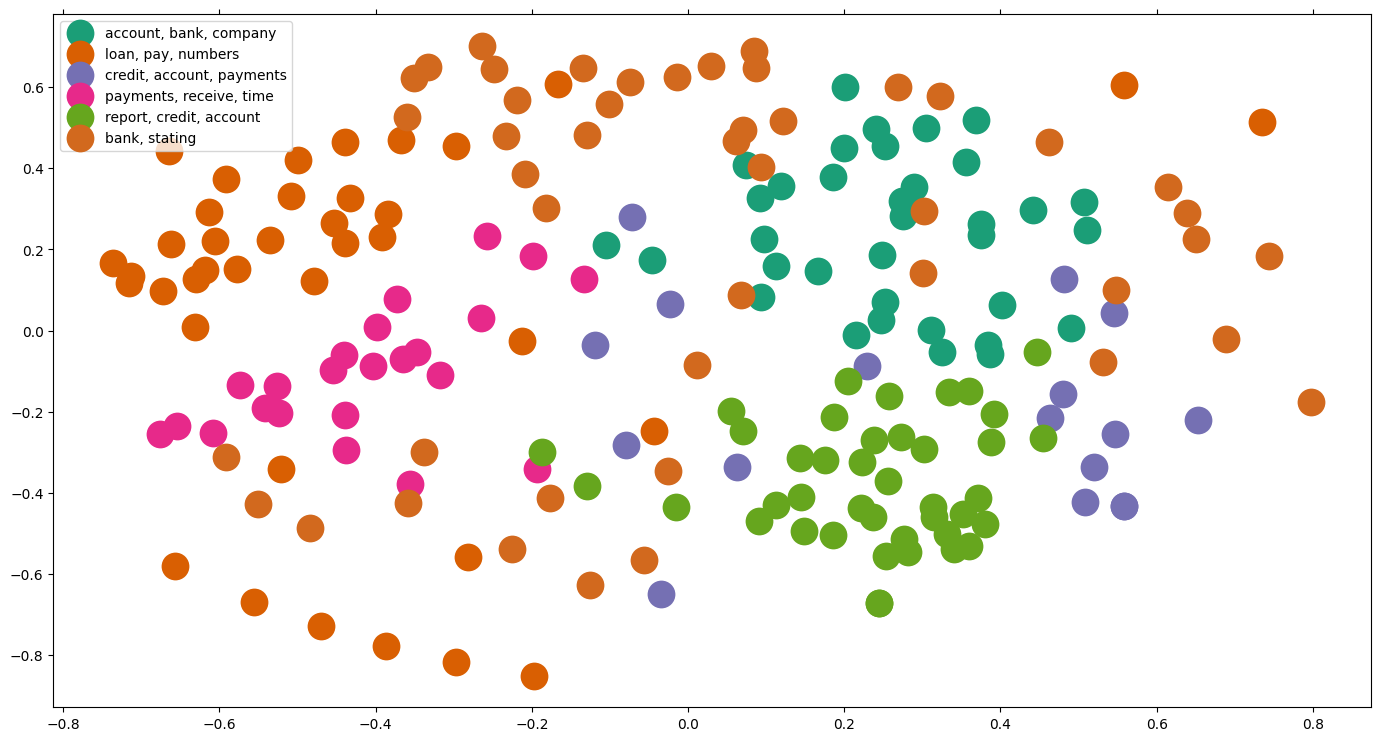

In [50]:
# Графикийн хэмжээ (өргөн, өндөр) тохируулах
fig, ax = plt.subplots(figsize=(17, 9))

# Кластер бүрийг өнгө, нэрээр ялган график дээр зурах
for name, group in groups:
    ax.plot(group.x, group.y,              # X ба Y координат
            marker = 'o',                     # Дугуй marker
            linestyle = '',                   # Шугамгүй (зөвхөн цэг)
            ms = 20,                          # Marker-ийн хэмжээ
            label = cluster_names[name],      # Кластерын тайлбар нэр
            color = cluster_colors[name],     # Өнгө
            mec = 'none')                     # Marker-ийн ирмэг өнгөгүй
    # Тэгш өнцөгт харьцаа тохируулах
    ax.set_aspect('auto')
    # X тэнхлэгийн тэмдэглэгээг устгах
    ax.tick_params(\
        axis = 'x',
        which = 'both',
        bottom = 'off',
        top = 'off',
        labelbottom = 'off')
    # Y тэнхлэгийн тэмдэглэгээг устгах
    ax.tick_params(\
        axis = 'y',
        which = 'both',
        left = 'off',
        top = 'off',
        labelleft = 'off')

ax.legend(numpoints=1)
plt.show()
